In [1]:
import pandas as pd
import numpy as np
import re
from string import digits
import numpy as np
import pandas as pd
import string, sys
from sklearn import metrics as evaluators
from sklearn.model_selection import cross_validate
from pymongo import MongoClient 
from sshtunnel import SSHTunnelForwarder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

## 串接MongoDB的資料庫

In [2]:
server = SSHTunnelForwarder(('140.127.32.24',22),
    ssh_password='npustMIS2023',
    ssh_username='chiayu',
    remote_bind_address=('140.127.32.23', 27016)
)

mongo_user = 'senior01'
mongo_password = 'senior018787'

server.start()
# print(server.local_bind_port)
client = MongoClient('127.0.0.1',server.local_bind_port)
client.admin.authenticate(mongo_user,mongo_password)
#db_name = client['medicine']
print('Done')

Done


In [3]:
db_name = client['medicine']
data = db_name['IM_alldata'].find()
agedata = db_name['HELNO_CHTNO'].find()
datadf = pd.DataFrame(list(data))
agedata = pd.DataFrame(list(agedata))
print(datadf)
print(agedata)

                            _id    年份            健診號       病歷號  性別   年齡   尿酸  \
0      6564a85c16d962e4e681866a  2010  2010010401001   9764229   1  0.0  4.6   
1      6564a85c16d962e4e681866b  2010  2010010401003  20834735   1  2.0  6.5   
2      6564a85c16d962e4e681866c  2010  2010010401005   2834286   0  2.0  3.1   
3      6564a85c16d962e4e681866d  2010  2010010401006  20863610   1  1.0  5.5   
4      6564a85c16d962e4e681866e  2010  2010010401009   3901976   0  1.0  4.7   
...                         ...   ...            ...       ...  ..  ...  ...   
59138  6564b73a16d962e4e6826d6c  2014  2014123101068    539434   1  NaN  9.3   
59139  6564b73a16d962e4e6826d6d  2014  2014123101069   8000050   1  1.0  5.2   
59140  6564b73a16d962e4e6826d6e  2014  2014123101071   2147418   0  1.0  4.3   
59141  6564b73a16d962e4e6826d6f  2014  2014123101073  39118655   1  1.0  5.1   
59142  6564b73a16d962e4e6826d70  2014  2014123101076  39033805   1  NaN  NaN   

       紅血球色素    血小板   淋巴球  ...   齲齒  牙齒

## 將健檢病患的年齡作對應

In [4]:
HELNO = []
age_1 = []
for i in range(0,len(agedata)):
    HEL = agedata['健診號'][i]
    now = int(HEL[0:4]) - int(agedata['出生年'][i])
    HELNO.append(agedata['健診號'][i])
    age_1.append(now)
print(len(HELNO))
print(len(age_1))

70993
70993


In [5]:
for i in range(0,len(datadf)):
    try:
        temp = HELNO.index(datadf['健診號'][i])       
        datadf['年齡'][i] = int(age_1[temp])
    except:
        pass
print(datadf)

                            _id    年份            健診號       病歷號  性別    年齡   尿酸  \
0      6564a85c16d962e4e681866a  2010  2010010401001   9764229   1  33.0  4.6   
1      6564a85c16d962e4e681866b  2010  2010010401003  20834735   1  74.0  6.5   
2      6564a85c16d962e4e681866c  2010  2010010401005   2834286   0  73.0  3.1   
3      6564a85c16d962e4e681866d  2010  2010010401006  20863610   1  46.0  5.5   
4      6564a85c16d962e4e681866e  2010  2010010401009   3901976   0  51.0  4.7   
...                         ...   ...            ...       ...  ..   ...  ...   
59138  6564b73a16d962e4e6826d6c  2014  2014123101068    539434   1  42.0  9.3   
59139  6564b73a16d962e4e6826d6d  2014  2014123101069   8000050   1  54.0  5.2   
59140  6564b73a16d962e4e6826d6e  2014  2014123101071   2147418   0  46.0  4.3   
59141  6564b73a16d962e4e6826d6f  2014  2014123101073  39118655   1  41.0  5.1   
59142  6564b73a16d962e4e6826d70  2014  2014123101076  39033805   1  39.0  NaN   

       紅血球色素    血小板   淋巴球  

In [6]:
maxage = 0
minage = 100
for i in range(0,len(datadf)):
    if datadf['年齡'][i] > maxage:
        maxage = datadf['年齡'][i]
    if datadf['年齡'][i] < minage:
        minage = datadf['年齡'][i]
print(minage)
print(maxage)

2.0
101.0


## BMI分群

In [7]:
# 1表過輕、2表健康、3表過重、4表肥胖
for i in range(0,len(datadf)):
    body = datadf['BMI'][i]
    if body < 18.5:
        datadf['BMI'][i] = 1
    elif body >= 18.5 and body < 24:
        datadf['BMI'][i] = 2
    elif body >= 24 and body < 27:
        datadf['BMI'][i] = 3
    elif body >= 27:
        datadf['BMI'][i] = 4
print(pd.Series.value_counts(datadf['BMI']))

BMI
2.0    28428
3.0    16800
4.0    10625
1.0     2694
Name: count, dtype: int64


## 年齡分群

In [8]:
# 1表年輕人、2表中老年人、3表老年人
datadf['年齡分群'] = 0
for i in range(0,len(datadf)):
    if datadf['年齡'][i] < 40:
        datadf['年齡分群'][i] = 0
    elif datadf['年齡'][i] >= 40 and datadf['年齡'][i] < 70:
        datadf['年齡分群'][i] = 1
    elif datadf['年齡'][i] >= 70:
        datadf['年齡分群'][i] = 2
print(pd.Series.value_counts(datadf['年齡分群']))

年齡分群
1    41201
0    13297
2     4645
Name: count, dtype: int64


In [9]:
# 分為男女後，再分成40歲以下、40-70歲、70歲以上
column = ['健診號', '病歷號', '性別', '年齡', '尿酸', '紅血球色素', '血小板', '淋巴球',
       '嗜中性球', '單核球', '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', 'HDL',
       '收縮壓', '舒張壓', '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma',
       'Triglyceride Glucose Index', 'Monocyte to Lymphocyte Ratio', 'SIRI',
       'SII', '大腸息肉', 'HP', '胃息肉', '切片腺瘤', '增生性息肉', '腺性息肉', '大腸切片息肉', '腸黏膜化生',
       '牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '胃潰瘍', '胃炎', '膽囊息肉', '膽囊結石', '脂肪肝', 'AST',
       'Hs-CRP', '年齡分群']

boy0 = pd.DataFrame(columns = column)
boy1 = pd.DataFrame(columns = column)
boy2 = pd.DataFrame(columns = column)
girl0 = pd.DataFrame(columns = column)
girl1 = pd.DataFrame(columns = column)
girl2 = pd.DataFrame(columns = column)

with tqdm(total=len(datadf)) as pbar:
    for i in range(0,len(datadf)):
        tempdf = datadf.iloc[[i]]  # 使用雙重中括號將其轉換為 DataFrame
        #tempdf.reset_index(drop=True, inplace=True)  # 重新設置索引
        # 0表女生、1表男生
        if datadf['性別'][i] == 0:
            if datadf['年齡分群'][i] == 0:
                #tempdf = datadf.iloc[i]
                girl0 = pd.concat([girl0, tempdf], ignore_index=True)
            elif datadf['年齡分群'][i] == 1:
                #tempdf = datadf.iloc[i]
                girl1 = pd.concat([girl1, tempdf], ignore_index=True)
            elif datadf['年齡分群'][i] == 2:
                #tempdf = datadf.iloc[i]
                girl2 = pd.concat([girl2, tempdf], ignore_index=True)
        elif datadf['性別'][i] == 1:
            if datadf['年齡分群'][i] == 0:
                #tempdf = datadf.iloc[i]
                boy0 = pd.concat([boy0, tempdf], ignore_index=True)
            elif datadf['年齡分群'][i] == 1:
                #tempdf = datadf.iloc[i]
                boy1 = pd.concat([boy1, tempdf], ignore_index=True)
            elif datadf['年齡分群'][i] == 2:
                #tempdf = datadf.iloc[i]
                boy2 = pd.concat([boy2, tempdf], ignore_index=True)
        pbar.update(1)
print(pd.Series.value_counts(boy0['年齡分群']))
print(pd.Series.value_counts(boy1['年齡分群']))
print(pd.Series.value_counts(boy2['年齡分群']))
print(pd.Series.value_counts(girl0['年齡分群']))
print(pd.Series.value_counts(girl1['年齡分群']))
print(pd.Series.value_counts(girl2['年齡分群']))

100%|███████████████████████████████████████████████████████████████████████████| 59143/59143 [00:47<00:00, 1241.98it/s]

年齡分群
0    8175
Name: count, dtype: int64
年齡分群
1    25310
Name: count, dtype: int64
年齡分群
2    2433
Name: count, dtype: int64
年齡分群
0    5122
Name: count, dtype: int64
年齡分群
1    15891
Name: count, dtype: int64
年齡分群
2    2212
Name: count, dtype: int64


## 性別分群

In [10]:
# 0表女生、1表男生
datadf['性別分群'] = 0
for i in range(0,len(datadf)):
    if datadf['性別'][i] == 0:
        datadf['性別分群'][i] = 0
    elif datadf['性別'][i] == 1:
        datadf['性別分群'][i] = 1
print(pd.Series.value_counts(datadf['性別分群']))

性別分群
1    35918
0    23225
Name: count, dtype: int64


In [11]:
# 只對性別作分群
column = ['健診號', '病歷號', '性別', '年齡', '尿酸', '紅血球色素', '血小板', '淋巴球',
       '嗜中性球', '單核球', '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', 'HDL',
       '收縮壓', '舒張壓', '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma',
       'Triglyceride Glucose Index', 'Monocyte to Lymphocyte Ratio', 'SIRI',
       'SII', '大腸息肉', 'HP', '胃息肉', '切片腺瘤', '增生性息肉', '腺性息肉', '大腸切片息肉', '腸黏膜化生',
       '牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '胃潰瘍', '胃炎', '膽囊息肉', '膽囊結石', '脂肪肝', 'AST',
       'Hs-CRP', '性別分群']
boy = pd.DataFrame(columns = column)
girl = pd.DataFrame(columns = column)
with tqdm(total=len(datadf)) as pbar:
    for i in range(0,len(datadf)):
        tempdf = datadf.iloc[[i]] # 使用雙重中括號將其轉換為 DataFrame
        if datadf['性別分群'][i] == 0:
            #tempdf = datadf.iloc[i]
            girl = pd.concat([girl, tempdf], ignore_index=True)
        elif datadf['性別分群'][i] == 1:
            #tempdf = datadf.iloc[i]
            boy = pd.concat([boy, tempdf], ignore_index=True)
        pbar.update(1)
print(pd.Series.value_counts(boy['性別分群']))
print(pd.Series.value_counts(girl['性別分群']))

100%|████████████████████████████████████████████████████████████████████████████| 59143/59143 [01:09<00:00, 845.93it/s]

性別分群
1.0    35918
Name: count, dtype: int64
性別分群
0.0    23225
Name: count, dtype: int64


In [12]:
import math

# NLR算法
datadf['Neutrophil-to-Lymphocyte Ratio'] = 0
for i in range(0,59143):
    datadf['Neutrophil-to-Lymphocyte Ratio'][i] = float(datadf['嗜中性球'][i]) / float(datadf['淋巴球'][i])       
datadf = datadf.reset_index(drop=True)
print(datadf)

                            _id    年份            健診號       病歷號  性別    年齡   尿酸  \
0      6564a85c16d962e4e681866a  2010  2010010401001   9764229   1  33.0  4.6   
1      6564a85c16d962e4e681866b  2010  2010010401003  20834735   1  74.0  6.5   
2      6564a85c16d962e4e681866c  2010  2010010401005   2834286   0  73.0  3.1   
3      6564a85c16d962e4e681866d  2010  2010010401006  20863610   1  46.0  5.5   
4      6564a85c16d962e4e681866e  2010  2010010401009   3901976   0  51.0  4.7   
...                         ...   ...            ...       ...  ..   ...  ...   
59138  6564b73a16d962e4e6826d6c  2014  2014123101068    539434   1  42.0  9.3   
59139  6564b73a16d962e4e6826d6d  2014  2014123101069   8000050   1  54.0  5.2   
59140  6564b73a16d962e4e6826d6e  2014  2014123101071   2147418   0  46.0  4.3   
59141  6564b73a16d962e4e6826d6f  2014  2014123101073  39118655   1  41.0  5.1   
59142  6564b73a16d962e4e6826d70  2014  2014123101076  39033805   1  39.0  NaN   

       紅血球色素    血小板   淋巴球  

In [13]:
# NLR分性別
import math
boy['Neutrophil-to-Lymphocyte Ratio'] = 0
girl['Neutrophil-to-Lymphocyte Ratio'] = 0

for i in range(0,35918):
    boy['Neutrophil-to-Lymphocyte Ratio'][i] = float(boy['嗜中性球'][i]) / float(boy['淋巴球'][i])        
boy = boy.reset_index(drop=True)

for i in range(0,23225):
    girl['Neutrophil-to-Lymphocyte Ratio'][i] = float(girl['嗜中性球'][i]) / float(girl['淋巴球'][i])        
girl = girl.reset_index(drop=True)

print(boy)
print(girl)

                 健診號       病歷號 性別    年齡   尿酸  紅血球色素    血小板   淋巴球  嗜中性球  單核球  \
0      2010010401001   9764229  1  33.0  4.6   31.1  194.0  23.2  69.7  6.0   
1      2010010401003  20834735  1  74.0  6.5   30.8  166.0  18.0  77.0  5.0   
2      2010010401006  20863610  1  46.0  5.5   27.6  185.0  29.4  61.8  7.2   
3      2010010401012   3651793  1  37.0  6.1   30.2  246.0  35.9  52.6  6.3   
4      2010010401013  21316965  1  41.0  7.8   31.8  303.0  27.5  63.9  6.1   
...              ...       ... ..   ...  ...    ...    ...   ...   ...  ...   
35913  2014123101065   2896615  1  45.0  5.5   20.8  261.0  35.5  57.3  4.5   
35914  2014123101068    539434  1  42.0  9.3   28.9  309.0  17.1  69.1  5.2   
35915  2014123101069   8000050  1  54.0  5.2   30.7  193.0  35.3  52.8  7.5   
35916  2014123101073  39118655  1  41.0  5.1   29.7  186.0  37.7  53.1  6.9   
35917  2014123101076  39033805  1  39.0  NaN    NaN    NaN   NaN   NaN  NaN   

       ...  膽囊息肉  膽囊結石  脂肪肝   AST  Hs-CRP  年齡分群    

In [14]:
# NLR分性別跟年齡
import math
boy0['Neutrophil-to-Lymphocyte Ratio'] = 0
boy1['Neutrophil-to-Lymphocyte Ratio'] = 0
boy2['Neutrophil-to-Lymphocyte Ratio'] = 0
girl0['Neutrophil-to-Lymphocyte Ratio'] = 0
girl1['Neutrophil-to-Lymphocyte Ratio'] = 0
girl2['Neutrophil-to-Lymphocyte Ratio'] = 0

for i in range(0,8175):
    boy0['Neutrophil-to-Lymphocyte Ratio'][i] = float(boy0['嗜中性球'][i]) / float(boy0['淋巴球'][i])        
boy0 = boy0.reset_index(drop=True)

for i in range(0,25310):
    boy1['Neutrophil-to-Lymphocyte Ratio'][i] = float(boy1['嗜中性球'][i]) / float(boy1['淋巴球'][i])        
boy1 = boy1.reset_index(drop=True)

for i in range(0,2433):
    boy2['Neutrophil-to-Lymphocyte Ratio'][i] = float(boy2['嗜中性球'][i]) / float(boy2['淋巴球'][i])        
boy2 = boy2.reset_index(drop=True)

for i in range(0,5122):
    girl0['Neutrophil-to-Lymphocyte Ratio'][i] = float(girl0['嗜中性球'][i]) / float(girl0['淋巴球'][i])        
girl0 = girl0.reset_index(drop=True)

for i in range(0,15891):
    girl1['Neutrophil-to-Lymphocyte Ratio'][i] = float(girl1['嗜中性球'][i]) / float(girl1['淋巴球'][i])        
girl1 = girl1.reset_index(drop=True)

for i in range(0,2212):
    girl2['Neutrophil-to-Lymphocyte Ratio'][i] = float(girl2['嗜中性球'][i]) / float(girl2['淋巴球'][i])        
girl2 = girl2.reset_index(drop=True)

print(boy0)

                健診號       病歷號 性別    年齡   尿酸  紅血球色素    血小板   淋巴球  嗜中性球  單核球  \
0     2010010401001   9764229  1  33.0  4.6   31.1  194.0  23.2  69.7  6.0   
1     2010010401012   3651793  1  37.0  6.1   30.2  246.0  35.9  52.6  6.3   
2     2010010401016  21316963  1  31.0  8.4   31.5  341.0  43.0  52.0  5.0   
3     2010010401028  21316961  1  38.0  6.1   30.7  314.0  30.3  56.2  4.2   
4     2010010401030  21316964  1  29.0  7.2   28.8  216.0  28.7  64.0  6.1   
...             ...       ... ..   ...  ...    ...    ...   ...   ...  ...   
8170  2014123101048  39211465  1  29.0  4.6   32.3  245.0  33.6  58.2  7.0   
8171  2014123101057  99087460  1  34.0  7.9   29.4  266.0  37.9  52.7  5.1   
8172  2014123101058   2811350  1  33.0  4.5   31.7  197.0  32.1  61.3  5.0   
8173  2014123101059  10419696  1  39.0  7.0   30.5  310.0  38.0  57.7  2.7   
8174  2014123101076  39033805  1  39.0  NaN    NaN    NaN   NaN   NaN  NaN   

      ...   胃炎  膽囊息肉  膽囊結石  脂肪肝   AST  Hs-CRP  年齡分群            

In [15]:
# VAI分性別
import math

boy['Visceral adiposity index'] = 0
girl['Visceral adiposity index'] = 0

for i in range(0,35918):
    boy['Visceral adiposity index'][i] = (float(boy['腰圍'][i]) / (39.68+(1.88 * float(boy['BMI'][i])))) * (float(boy['三酸甘油脂'][i]) / 1.03) * (1.31 / float(boy['HDL'][i]))       
boy = boy.reset_index(drop=True)

for i in range(0,23225):
    girl['Visceral adiposity index'][i] = (float(girl['腰圍'][i]) / (36.58+(1.89 * float(girl['BMI'][i])))) * (float(girl['三酸甘油脂'][i]) / 0.81) * (1.52 / float(girl['HDL'][i]))     
girl = girl.reset_index(drop=True)

In [16]:
# VAI性別跟年齡
import math

boy0['Visceral adiposity index'] = 0
boy1['Visceral adiposity index'] = 0
boy2['Visceral adiposity index'] = 0
girl0['Visceral adiposity index'] = 0
girl1['Visceral adiposity index'] = 0
girl2['Visceral adiposity index'] = 0

for i in range(0,8175):
    boy0['Visceral adiposity index'][i] = (float(boy0['腰圍'][i]) / (39.68+(1.88 * float(boy0['BMI'][i])))) * (float(boy0['三酸甘油脂'][i]) / 1.03) * (1.31 / float(boy0['HDL'][i]))       
boy0 = boy0.reset_index(drop=True)

for i in range(0,25310):
    boy1['Visceral adiposity index'][i] = (float(boy1['腰圍'][i]) / (39.68+(1.88 * float(boy1['BMI'][i])))) * (float(boy1['三酸甘油脂'][i]) / 1.03) * (1.31 / float(boy1['HDL'][i]))         
boy1 = boy1.reset_index(drop=True)

for i in range(0,2433):
    boy2['Visceral adiposity index'][i] = (float(boy2['腰圍'][i]) / (39.68+(1.88 * float(boy2['BMI'][i])))) * (float(boy2['三酸甘油脂'][i]) / 1.03) * (1.31 / float(boy2['HDL'][i]))      
boy2 = boy2.reset_index(drop=True)

for i in range(0,5122):
    girl0['Visceral adiposity index'][i] = (float(girl0['腰圍'][i]) / (36.58+(1.89 * float(girl0['BMI'][i])))) * (float(girl0['三酸甘油脂'][i]) / 0.81) * (1.52 / float(girl0['HDL'][i]))  
girl0 = girl0.reset_index(drop=True)

for i in range(0,15891):
    girl1['Visceral adiposity index'][i] = (float(girl1['腰圍'][i]) / (36.58+(1.89 * float(girl1['BMI'][i])))) * (float(girl1['三酸甘油脂'][i]) / 0.81) * (1.52 / float(girl1['HDL'][i]))         
girl1 = girl1.reset_index(drop=True)

for i in range(0,2212):
    girl2['Visceral adiposity index'][i] = (float(girl2['腰圍'][i]) / (36.58+(1.89 * float(girl2['BMI'][i])))) * (float(girl2['三酸甘油脂'][i]) / 0.81) * (1.52 / float(girl2['HDL'][i]))         
girl2 = girl2.reset_index(drop=True)

In [17]:
bb = boy.copy()
gg = girl.copy()

In [18]:
temp_1 = boy0.copy()
#temp_1
temp_2 = boy1.copy()
#temp_2
temp_3 = boy2.copy()
#temp_3
temp_4 = girl0.copy()
#temp_4
temp_5 = girl1.copy()
#temp_5
temp_6 = girl2.copy()

## 去除用不到的欄位

In [19]:
datadf.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)
print(datadf)

                            _id    年份            健診號       病歷號  性別    年齡   尿酸  \
0      6564a85c16d962e4e681866a  2010  2010010401001   9764229   1  33.0  4.6   
1      6564a85c16d962e4e681866b  2010  2010010401003  20834735   1  74.0  6.5   
2      6564a85c16d962e4e681866c  2010  2010010401005   2834286   0  73.0  3.1   
3      6564a85c16d962e4e681866d  2010  2010010401006  20863610   1  46.0  5.5   
4      6564a85c16d962e4e681866e  2010  2010010401009   3901976   0  51.0  4.7   
...                         ...   ...            ...       ...  ..   ...  ...   
59138  6564b73a16d962e4e6826d6c  2014  2014123101068    539434   1  42.0  9.3   
59139  6564b73a16d962e4e6826d6d  2014  2014123101069   8000050   1  54.0  5.2   
59140  6564b73a16d962e4e6826d6e  2014  2014123101071   2147418   0  46.0  4.3   
59141  6564b73a16d962e4e6826d6f  2014  2014123101073  39118655   1  41.0  5.1   
59142  6564b73a16d962e4e6826d70  2014  2014123101076  39033805   1  39.0  NaN   

       紅血球色素    血小板   淋巴球  

In [20]:
bb.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)
gg.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)

In [21]:
temp_1.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)
temp_2.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)
temp_3.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)
temp_4.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)
temp_5.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)
temp_6.drop(['大腸息肉','胃息肉','切片腺瘤','增生性息肉','腺性息肉','大腸切片息肉'], axis=1, inplace=True)

In [22]:
datadf.replace('',np.nan, inplace=True)
datadf.dropna(axis=0, inplace=True)
datadf.reset_index(drop=True,inplace=True)
print(pd.Series.value_counts(datadf['腸黏膜化生']))
print(datadf)

腸黏膜化生
0.0    8292
1.0    2088
Name: count, dtype: int64
                            _id    年份            健診號       病歷號  性別    年齡   尿酸  \
0      6564a85c16d962e4e6818671  2010  2010010401013  21316965   1  41.0  7.8   
1      6564a85c16d962e4e6818675  2010  2010010401018  20226466   1  54.0  5.9   
2      6564a85c16d962e4e681867a  2010  2010010401028  21316961   1  38.0  6.1   
3      6564a85c16d962e4e6818681  2010  2010010401042   2590750   1  66.0  5.8   
4      6564a85c16d962e4e6818692  2010  2010010402028   3810044   0  59.0  4.7   
...                         ...   ...            ...       ...  ..   ...  ...   
10375  6564b73a16d962e4e6826d4e  2014  2014123101016  39211331   0  50.0  5.4   
10376  6564b73a16d962e4e6826d5a  2014  2014123101039  39019960   0  41.0  5.1   
10377  6564b73a16d962e4e6826d5f  2014  2014123101049  21016603   1  47.0  8.0   
10378  6564b73a16d962e4e6826d61  2014  2014123101052   2946846   1  67.0  8.9   
10379  6564b73a16d962e4e6826d6e  2014  2014123101071 

In [23]:
bb.replace('',np.nan, inplace=True)
bb.dropna(axis=0, inplace=True)
bb.reset_index(drop=True,inplace=True)
print(pd.Series.value_counts(bb['腸黏膜化生']))
print(bb)

gg.replace('',np.nan, inplace=True)
gg.dropna(axis=0, inplace=True)
gg.reset_index(drop=True,inplace=True)
print(pd.Series.value_counts(gg['腸黏膜化生']))
print(gg)

腸黏膜化生
0.0    4732
1.0    1447
Name: count, dtype: int64
                健診號       病歷號 性別    年齡   尿酸  紅血球色素    血小板   淋巴球  嗜中性球  單核球  \
0     2010010401013  21316965  1  41.0  7.8   31.8  303.0  27.5  63.9  6.1   
1     2010010401018  20226466  1  54.0  5.9   22.6  197.0  32.1  56.4  8.1   
2     2010010401028  21316961  1  38.0  6.1   30.7  314.0  30.3  56.2  4.2   
3     2010010401042   2590750  1  66.0  5.8   30.6  366.0  30.9  60.3  4.1   
4     2010010402032   2304721  1  52.0  8.1   29.8  268.0  35.5  55.5  6.2   
...             ...       ... ..   ...  ...    ...    ...   ...   ...  ...   
6174  2014123001086  10652468  1  54.0  4.8   30.8  211.0  38.5  51.8  6.5   
6175  2014123101012  39211333  1  62.0  5.5   31.7  243.0  37.3  55.9  5.2   
6176  2014123101015  20314919  1  32.0  9.4   21.7  160.0  37.1  57.0  5.3   
6177  2014123101049  21016603  1  47.0  8.0   30.7  190.0  35.5  56.8  5.3   
6178  2014123101052   2946846  1  67.0  8.9   31.6  244.0  41.5  45.4  7.5   

      .

In [24]:
temp_1.replace('',np.nan, inplace=True)
temp_1.dropna(axis=0, inplace=True)
temp_1.reset_index(drop=True,inplace=True)
print(pd.Series.value_counts(temp_1['腸黏膜化生']))
#print(temp_1)

temp_2.replace('',np.nan, inplace=True)
temp_2.dropna(axis=0, inplace=True)
temp_2.reset_index(drop=True,inplace=True)
#print(pd.Series.value_counts(temp_2['腸黏膜化生']))
#print(temp_2)

temp_3.replace('',np.nan, inplace=True)
temp_3.dropna(axis=0, inplace=True)
temp_3.reset_index(drop=True,inplace=True)
#print(pd.Series.value_counts(temp_3['腸黏膜化生']))
#print(temp_3)

temp_4.replace('',np.nan, inplace=True)
temp_4.dropna(axis=0, inplace=True)
temp_4.reset_index(drop=True,inplace=True)
#print(pd.Series.value_counts(temp_4['腸黏膜化生']))
#print(temp_4)

temp_5.replace('',np.nan, inplace=True)
temp_5.dropna(axis=0, inplace=True)
temp_5.reset_index(drop=True,inplace=True)
#print(pd.Series.value_counts(temp_5['腸黏膜化生']))
#print(temp_5)

temp_6.replace('',np.nan, inplace=True)
temp_6.dropna(axis=0, inplace=True)
temp_6.reset_index(drop=True,inplace=True)

腸黏膜化生
0.0    733
1.0    157
Name: count, dtype: int64


## 簡單展示最終的欄位

In [25]:
print(datadf.columns)

Index(['_id', '年份', '健診號', '病歷號', '性別', '年齡', '尿酸', '紅血球色素', '血小板', '淋巴球',
       '嗜中性球', '單核球', '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', 'HDL',
       '收縮壓', '舒張壓', '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma',
       'Triglyceride Glucose Index', 'Monocyte to Lymphocyte Ratio', 'SIRI',
       'SII', 'HP', '腸黏膜化生', '牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '胃潰瘍', '胃炎', '膽囊息肉',
       '膽囊結石', '脂肪肝', 'AST', 'Hs-CRP', '年齡分群', '性別分群',
       'Neutrophil-to-Lymphocyte Ratio'],
      dtype='object')


In [26]:
print(bb.columns)

Index(['健診號', '病歷號', '性別', '年齡', '尿酸', '紅血球色素', '血小板', '淋巴球', '嗜中性球', '單核球',
       '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', 'HDL', '收縮壓', '舒張壓',
       '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma',
       'Triglyceride Glucose Index', 'Monocyte to Lymphocyte Ratio', 'SIRI',
       'SII', 'HP', '腸黏膜化生', '牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '胃潰瘍', '胃炎', '膽囊息肉',
       '膽囊結石', '脂肪肝', 'AST', 'Hs-CRP', '年齡分群', '_id', '年份', '性別分群',
       'Neutrophil-to-Lymphocyte Ratio', 'Visceral adiposity index'],
      dtype='object')


In [27]:
print(temp_1.columns)

Index(['健診號', '病歷號', '性別', '年齡', '尿酸', '紅血球色素', '血小板', '淋巴球', '嗜中性球', '單核球',
       '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', 'HDL', '收縮壓', '舒張壓',
       '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma',
       'Triglyceride Glucose Index', 'Monocyte to Lymphocyte Ratio', 'SIRI',
       'SII', 'HP', '腸黏膜化生', '牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '胃潰瘍', '胃炎', '膽囊息肉',
       '膽囊結石', '脂肪肝', 'AST', 'Hs-CRP', '年齡分群', '_id', '年份',
       'Neutrophil-to-Lymphocyte Ratio', 'Visceral adiposity index'],
      dtype='object')


# 發炎組

In [31]:
#發炎組
X = temp_6[['Monocyte to Lymphocyte Ratio', 'SIRI', 'SII', 'Hs-CRP', 'Neutrophil-to-Lymphocyte Ratio', 'HP', '血小板', '淋巴球', '嗜中性球', '單核球']]
y = temp_6['腸黏膜化生']
#y = y.astype(float)
print(pd.Series.value_counts(y))
#_c = X.columns
# X = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
# X_1 = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
X = X.astype(float)
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
print(pd.Series.value_counts(y_smote))
X_smote = X_smote.reset_index(drop=True)
y_smote = y_smote.reset_index(drop=True)

腸黏膜化生
0.0    185
1.0     37
Name: count, dtype: int64
腸黏膜化生
0.0    185
1.0    185
Name: count, dtype: int64


# 代謝組

In [34]:
#代謝組
X = temp_6[['尿酸', '紅血球色素', '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', '收縮壓', '舒張壓', 
        'HDL', '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma', 'Triglyceride Glucose Index',
        '脂肪肝', 'Visceral adiposity index']]
y = temp_6['腸黏膜化生']
print(pd.Series.value_counts(y))

#_c = X.columns
# X = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
# X_1 = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
X = X.astype(float)
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
print(pd.Series.value_counts(y_smote))
X_smote = X_smote.reset_index(drop=True)
y_smote = y_smote.reset_index(drop=True)

腸黏膜化生
0.0    185
1.0     37
Name: count, dtype: int64
腸黏膜化生
0.0    185
1.0    185
Name: count, dtype: int64


# 其他組

In [28]:
#其他組
X = temp_6[['牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '膽囊息肉', '膽囊結石', 'AST']]
y = temp_6['腸黏膜化生']
print(pd.Series.value_counts(y))
#_c = X.columns
# X = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
# X_1 = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
X = X.astype(float)
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
print(pd.Series.value_counts(y_smote))
X_smote = X_smote.reset_index(drop=True)
y_smote = y_smote.reset_index(drop=True)

腸黏膜化生
0.0    185
1.0     37
Name: count, dtype: int64
腸黏膜化生
0.0    185
1.0    185
Name: count, dtype: int64


## 針對各組做SMOTE

In [31]:
from imblearn.under_sampling import RandomUnderSampler
#未分組
X = temp_6[['年齡', '尿酸', '紅血球色素', '血小板', '淋巴球',
            '嗜中性球', '單核球', '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', 'HDL',
           '收縮壓', '舒張壓', '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma',
            'Triglyceride Glucose Index', 'Monocyte to Lymphocyte Ratio', 'SIRI', 'SII', 'HP',
           '牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '膽囊息肉', '膽囊結石', '脂肪肝', 'AST', 'Hs-CRP',
           'Neutrophil-to-Lymphocyte Ratio', 'Visceral adiposity index']]
y = temp_6['腸黏膜化生']
print(pd.Series.value_counts(y))

# X = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
# X_1 = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
X = X.astype(float)

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
print(pd.Series.value_counts(y_smote))
X_smote = X_smote.reset_index(drop=True)
y_smote = y_smote.reset_index(drop=True)
#print(x_rus)

腸黏膜化生
0.0    185
1.0     37
Name: count, dtype: int64
腸黏膜化生
0.0    185
1.0    185
Name: count, dtype: int64


In [55]:
from imblearn.under_sampling import RandomUnderSampler
#未分組
X = temp_6[['超低密度脂蛋白', '三酸甘油脂']]
y = temp_6['腸黏膜化生']
print(pd.Series.value_counts(y))

# X = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
# X_1 = resultdf[['性別','年齡','血小板','淋巴球','嗜中性球','膽固醇總量','BMI','腰圍','三酸甘油脂','低密度脂蛋白','Atherogenic Index of Plasma','超低密度脂蛋白','HP','大腸切片息肉']]
X = X.astype(float)

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
print(pd.Series.value_counts(y_smote))
X_smote = X_smote.reset_index(drop=True)
y_smote = y_smote.reset_index(drop=True)

腸黏膜化生
0.0    185
1.0     37
Name: count, dtype: int64
腸黏膜化生
0.0    185
1.0    185
Name: count, dtype: int64


## 迴歸分析後各變數的統計值

In [44]:
from scipy import stats
from scipy.stats import levene
from scipy.stats import ttest_ind

IM_0 = []
IM_1 = []
for i in range(0,len(X)):
    if y[i] == 0:
        IM_0.append(X['Neutrophil-to-Lymphocyte Ratio'][i])
    elif y[i] == 1:
        IM_1.append(X['Neutrophil-to-Lymphocyte Ratio'][i])

#'年齡', '尿酸', '紅血球色素', '血小板', '淋巴球',
#       '嗜中性球', '單核球', '飯前血糖', '飯後血糖', '膽固醇總量', 'BMI', '腰圍', '三酸甘油脂', 'HDL',
#       '收縮壓', '舒張壓', '低密度脂蛋白', '超低密度脂蛋白', 'Atherogenic Index of Plasma',
#       'Triglyceride Glucose Index', 'Monocyte to Lymphocyte Ratio', 'SIRI',
#       'SII', 'HP', '牙結石', '齲齒', '牙齒缺失', '慢性齒齦炎', '膽囊息肉',
#       '膽囊結石', '脂肪肝', 'AST', 'Hs-CRP', 'Neutrophil-to-Lymphocyte Ratio',
#        'AST * Monocyte to Lymphocyte Ratio', 'Visceral adiposity index'
#IM_1
#statistic, p_value = levene(IM_0, IM_1)
#print('統計量：%.2f'%statistic)
#print('p-value:%.2f'%p_value)
t_statistic, p_value = ttest_ind(IM_0, IM_1, equal_var=True, alternative='two-sided')
#t_statistic, p_value = ttest_ind(IM_0, IM_1, alternative='two-sided')
print(t_statistic)
print(p_value)
print("T-statistic:", t_statistic)
print(f"P-value: {p_value}")

mean_1 = np.mean(IM_0)
std_1 = np.std(IM_0)

mean_2 = np.mean(IM_1)
std_2 = np.std(IM_1)

print('Control')
print('Control:',mean_1)
print(std_1)
print('IM')
print('IM:',mean_2)
print(std_2)

1.4278988492425069
0.15338389483618198
T-statistic: 1.4278988492425069
P-value: 0.15338389483618198
Control
Control: 1.8673210654350179
0.9729457402185767
IM
IM: 1.822314264886314
0.8933082338056355


In [ ]:
# 若為類別變數
print(pd.Series.value_counts(IM_0))
print(pd.Series.value_counts(IM_1))

## Stepwise

In [29]:
import statsmodels.api as sm
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in = 0.05,
                       threshold_out = 0.05,
                       verbose = True):
    '''
     threshold_out为t检验，threshold_in为F检验
     X：待筛选变量
     y：好坏标签
     '''
    #included = list(initial_list)
    included = []
    while True:
        changed=False

        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit(disp=False)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:#F检验最小的显著性小于临界值，说明该变量有显著意义
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=False)

        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        print('here')
        if worst_pval > threshold_out:#T检验最大的大于临界值，说明该变量无显著意义。
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=False)
    print(model.summary2())
    print(np.exp(model.params))
    std_errors = model.bse
    print(np.exp((model.params) - 1.96 * std_errors))
    print(np.exp((model.params) + 1.96 * std_errors))
    auc = metrics.roc_auc_score(y,model.predict())
    #print AUC score
    print(auc)
    return included

In [30]:
select_col = stepwise_selection(X_smote, y_smote)
print(select_col)

Add  牙齒缺失                           with p-value 0.000286861
here
Add  膽囊息肉                           with p-value 0.000857751
here
Add  齲齒                             with p-value 0.00731887
here
here
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.069     
Dependent Variable: 腸黏膜化生            AIC:              485.7614  
Date:               2024-08-15 11:40 BIC:              501.4155  
No. Observations:   370              Log-Likelihood:   -238.88   
Df Model:           3                LL-Null:          -256.46   
Df Residuals:       366              LLR p-value:      1.1229e-07
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      0.1207     0.13

In [31]:
#X_train, X_test,y_train, y_test = train_test_split(X_smote, y_smote ,random_state=42, test_size=0.3, shuffle=True) 
#odel = sm.Logit(y_train,X_train).fit(disp=False)
#print(model.summary2())
#y_pred = model.predict(X_test)

In [72]:
X_select = X_smote[select_col]
print(X_select)

           HP
0    1.000000
1    1.000000
2    0.000000
3    1.000000
4    1.000000
..        ...
365  0.000000
366  0.846397
367  0.000000
368  0.165175
369  0.616171

[370 rows x 1 columns]


In [73]:
X_train, X_test,y_train, y_test = train_test_split(X_select, y_smote ,random_state=42, test_size=0.3, shuffle=True) 
model = sm.Logit(y_train,X_train).fit(disp=False)
#print(model.summary2())
y_pred = model.predict(X_test)

Area under the ROC curve : 0.474172
        fpr       tpr     1-fpr        tf  thresholds
1  0.796296  0.701754  0.203704  0.498051         0.5


[Text(-0.5, 0, ''),
 Text(0.0, 0, ''),
 Text(0.5, 0, ''),
 Text(1.0, 0, ''),
 Text(1.5, 0, ''),
 Text(2.0, 0, ''),
 Text(2.5, 0, ''),
 Text(3.0, 0, ''),
 Text(3.5, 0, '')]

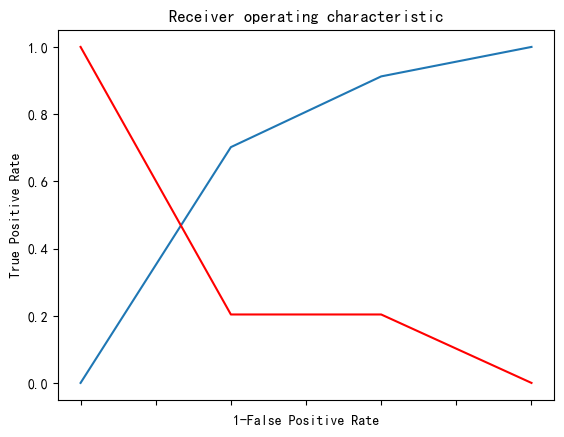

In [74]:
# 算出cut-off value
from sklearn.metrics import roc_curve, auc
import pylab as pl
# result = sm.Logit(y_train, X_train).fit(disp=False)
# print (result.summary())

# # Add prediction to dataframe
# y_pred = result.predict(X_test)vnb    nbv  


fpr, tpr, thresholds =roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc2 = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
print(roc2)

# Plot tpr vs 1-fpr
fig, ax = pl.subplots()
pl.plot(roc['tpr'])
pl.plot(roc['1-fpr'], color = 'red')
pl.xlabel('1-False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
ax.set_xticklabels([])